##Loading the drive

In [6]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -P drive/gaze
import keras
from keras.preprocessing import image
import matplotlib
import matplotlib.pyplot as plt
import cv2
import glob, random, math, numpy as np, dlib, itertools
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from PIL import Image
from google.colab.patches import cv2_imshow as imshow

--2019-04-22 03:03:22--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘drive/gaze/haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K   237KB/s    in 3.8s    

2019-04-22 03:03:28 (237 KB/s) - ‘drive/gaze/haarcascade_frontalface_default.xml’ saved [930127/930127]



Using TensorFlow backend.


In [0]:
import sys, os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.models import model_from_json
from keras.layers import AveragePooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [9]:
with open("/content/gdrive/My Drive/CSCE633Data/fer2013.csv") as f:
  content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)

number of instances:  35888


In [31]:
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 256
epochs = 5
x_train, y_train, x_test, y_test = [], [], [], []
for i in range(1,num_of_instances):
  try:
    emotion, img, usage = lines[i].split(",")
    val = img.split(" ")
    pixels = np.array(val, 'float32')
    emotion = keras.utils.to_categorical(emotion, num_classes)
    if ('Training'in usage):
         y_train.append(emotion)
         x_train.append(pixels)
    elif ('PublicTest'in usage):
         y_test.append(emotion)
         x_test.append(pixels)
  except:
       print("Empty", end="")
print(len(x_train),len(y_train))



28709 28709


In [0]:
emotions = ["Disgust","Angry","Fear","Surprise"]#, "Happy", "Neutral", "Sad"] #Emotion list
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/gdrive/My Drive/CSCE633Data/shape_predictor_68_face_landmarks.dat") 
def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
            
        xmean = np.mean(xlist) #Get the mean of both axes to determine centre of gravity
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist] #get distance between each point and the central point in both axes
        ycentral = [(y-ymean) for y in ylist]

        if xlist[26] == xlist[29]: #If x-coordinates of the set are the same, the angle is 0, catch to prevent 'divide by 0' error in function
            anglenose = 0
        else:
            anglenose = int(math.atan((ylist[26]-ylist[29])/(xlist[26]-xlist[29]))*180/math.pi)

        if anglenose < 0:
            anglenose += 90
        else:
            anglenose -= 90

        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(x)
            landmarks_vectorised.append(y)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            anglerelative = (math.atan((z-ymean)/(w-xmean))*180/math.pi) - anglenose
            landmarks_vectorised.append(dist)
            if anglerelative!=anglerelative:
                print(anglerelative,math.atan((z-ymean)/(w-xmean)),((z-ymean)/(w-xmean)),w,xmean)
                landmarks_vectorised.append(1.57*180/math.pi-anglenose)
            else:
                landmarks_vectorised.append(anglerelative)

    if len(detections) < 1: 
        landmarks_vectorised = "error"
    return landmarks_vectorised

In [0]:
def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
        xmean = np.mean(xlist) #Find both coordinates of centre of gravity
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist] #Calculate distance centre <-> other points in both axes
        ycentral = [(y-ymean) for y in ylist]
        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))
        #data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1:
        landmarks_vectorised = "error"
    return landmarks_vectorised

In [0]:
def vectorize(x,y):
    final_x=[]
    final_y=[]
    for i,im in enumerate(x):
            image = im.reshape(48,48)
            image = np.expand_dims(image, axis = 2)
            a=image
            a = np.concatenate((a, a, a), axis = 2)
            image=a
            
           # image=np.array(image[...,np.newaxis])
            
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray = np.array(gray)
            gray=gray.astype(np.uint8)
            clahe_image = clahe.apply(gray)
            landmarks_vectorised = get_landmarks(gray)
            if landmarks_vectorised == "error":
                pass
            else:
                final_x.append(landmarks_vectorised) #append image array to training data list
                final_y.append(y[i])
    return final_x,final_y
x_train_vec,y_train_vec=vectorize(x_train_crop,y_train_crop)
x_test_vec,y_test_vec=vectorize(x_test_crop,y_test_crop)

In [0]:
emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
path='drive/gaze/'
face_cascade = cv2.CascadeClassifier(path + 'haarcascade_frontalface_default.xml')
def cropfaces(x_data,y_data):
    final_x=[]
    final_y=[]
    for i,im in enumerate(x_data):
        image = im.reshape(48,48)
        image = np.expand_dims(image, axis = 2)
        image = np.concatenate((image, image, image), axis = 2)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray=np.array(gray)
        gray=gray.astype(np.uint8)
        img=gray
        faces = face_cascade.detectMultiScale(img)
        if (len(faces)==0):
          final_x.append(im) #store probabilities of 7 expressions
          final_y.append(y_data[i])
        else:
            for (x,y,w,h) in faces:
              #print(faces)
                  detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face
                  detected_face = np.expand_dims(detected_face, axis = 2)
                  detected_face = np.concatenate((detected_face, detected_face, detected_face), axis = 2)
                  detected_face = cv2.cvtColor(detected_face, cv2.COLOR_BGR2GRAY) #transform to gray scale
                  detected_face = cv2.resize(detected_face, (48, 48)) #resize to 48x48
                  img_pixels = list(detected_face.reshape(48*48)) #pixels are in scale of [0, 255]. normalize all pixels in scale of [0, 1]
                  final_x.append(img_pixels) #store probabilities of 7 expressions
                  final_y.append(y_data[i])
    return np.array(final_x),np.array(final_y)
x_train_crop,y_train_crop=(cropfaces(x_train,y_train))
x_test_crop,y_test_crop=(cropfaces(x_test,y_test))

In [0]:
x_train_crop /= 255 #normalize inputs between [0, 1]
x_test_crop /= 255

x_train_crop = x_train_crop.reshape(x_train_crop.shape[0], 48, 48, 1)
x_train_crop = x_train_crop.astype('float32')
x_test_crop = x_test_crop.reshape(x_test_crop.shape[0], 48, 48, 1)
x_test_crop = x_test_crop.astype('float32')

In [15]:
x_train_vec=np.array(x_train_vec)
x_test_vec = np.array(x_test_vec)
print(x_train_vec.shape, 'train samples')
y_train_vec=np.array([np.argmax(m) for m in y_train_vec])
y_test_vec=np.array([np.argmax(m) for m in y_test_vec])

(18411, 268) train samples


In [23]:
accur_lin=[]
clf = RandomForestClassifier(min_samples_leaf=9)
clf.fit(x_train_vec,y_train_vec)
#npar_pred = np.array(prediction_data)
pred_lin = clf.score(x_test_vec, y_test_vec)
print ("Model: ", pred_lin)
accur_lin.append(pred_lin) #Store accuracy in a list
p=clf.predict(x_test_vec)
print(p)
print("Mean value accuracy in Model: %.3f" %np.mean(accur_lin))
print(clf.predict(x_test_vec[:5]))
print(y_test_vec[:5])

Model:  0.5051903114186851
[3 6 2 ... 3 0 6]
Mean value accuracy in Model: 0.505
[3 6 2 3 6]
[0 4 6 3 0]


In [0]:
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

In [33]:
epochs = 100
batch_size = 256
learning_rate = 0.001
#construct CNN structure
model2 = Sequential()

#1st convolution layer
model2.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1),kernel_regularizer=l2(0.01)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))
model2.add(Dropout(0.5))

#2nd convolution layer
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))
model2.add(Dropout(0.5))

#3rd convolution layer
model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))
model2.add(Dropout(0.5))

model2.add(Flatten())

#fully connected neural networks
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.2))

model2.add(Dense(num_classes, activation='softmax'))
#------------------------------

#------------------------------
#batch process
gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)
#train_generator = gen.flow(x_train_crop, y_train_crop, batch_size=batch_size)

#------------------------------

model2.compile(loss='categorical_crossentropy'
    , optimizer=keras.optimizers.Adam()
    , metrics=['accuracy']
)
fit = True

if fit == True:
	#model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
	model2.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs,validation_data=(x_test, y_test)) #train for randomly selected one
else:
	model2.load_weights('/data/facial_expression_model_weights_2.h5') #load weights


Epoch 1/100
256/256 [==============================] - 15s 58ms/step - loss: 1.5473 - acc: 0.4026 - val_loss: 1.5946 - val_acc: 0.3909
Epoch 2/100
256/256 [==============================] - 13s 50ms/step - loss: 1.3303 - acc: 0.4992 - val_loss: 1.6732 - val_acc: 0.4439
Epoch 3/100
256/256 [==============================] - 13s 51ms/step - loss: 1.2558 - acc: 0.5270 - val_loss: 1.3457 - val_acc: 0.5199
Epoch 4/100
256/256 [==============================] - 13s 51ms/step - loss: 1.1970 - acc: 0.5519 - val_loss: 2.0724 - val_acc: 0.3165
Epoch 5/100
256/256 [==============================] - 13s 51ms/step - loss: 1.1404 - acc: 0.5747 - val_loss: 1.3177 - val_acc: 0.5224
Epoch 6/100
256/256 [==============================] - 13s 52ms/step - loss: 1.1188 - acc: 0.5819 - val_loss: 1.1960 - val_acc: 0.5670
Epoch 7/100
256/256 [==============================] - 13s 51ms/step - loss: 1.0778 - acc: 0.5997 - val_loss: 1.1904 - val_acc: 0.5712
Epoch 8/100
256/256 [==============================] - 

In [28]:
epochs = 100
batch_size = 256
learning_rate = 0.001
#construct CNN structure
model = Sequential()

#1st convolution layer
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1),kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))
model.add(Dropout(0.5))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.5))

#3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))
#------------------------------

#------------------------------
#batch process
gen = ImageDataGenerator()
#train_generator = gen.flow(x_train, y_train, batch_size=batch_size)
train_generator = gen.flow(x_train_crop, y_train_crop, batch_size=batch_size)

#------------------------------

model.compile(loss='categorical_crossentropy'
    , optimizer=keras.optimizers.Adam()
    , metrics=['accuracy']
)
fit = True

if fit == True:
	#model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
	model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs,validation_data=(x_test_crop, y_test_crop)) #train for randomly selected one
else:
	model.load_weights('/data/facial_expression_model_weights.h5') #load weights


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
256/256 [==============================] - 17s 67ms/step - loss: 1.5801 - acc: 0.3875 - val_loss: 1.7312 - val_acc: 0.3733
Epoch 2/100
256/256 [==============================] - 12s 46ms/step - loss: 1.3776 - acc: 0.4807 - val_loss: 1.3446 - val_acc: 0.4875
Epoch 3/100
256/256 [==============================] - 12s 47ms/step - loss: 1.2986 - acc: 0.5138 - val_loss: 1.3201 - val_acc: 0.4978
Epoch 4/100
256/256 [==============================] - 12s 46ms/step - loss: 1.2455 - acc: 0.5334 - val_loss: 1.3872 - val_acc: 0.4836
Epoch 5/100
256/256 [==============================] - 12s 47ms/step - loss: 1.2041 - acc: 0.5519 - val_loss: 1.1903 - val_acc: 0.5513
Epoch 6/100
256/256 [==============================] - 12s 47ms/step - loss: 1.1663 - acc: 0.5647 - val_loss: 1.2030 - val_acc: 0.5426
Epoch 7/100
256/256 [==============================] - 12s 47ms/step - loss: 1.1500 - acc: 0.5716 - val_loss: 1.1711 - val_acc: 0.5552
Epoch 8

In [30]:
scores = model.evaluate(x_test,y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
pred=model.predict(x_test[:2])
print(pred,(y_test[:2]))

3589/3589 [==============================] - 0s 125us/step

acc: 61.33%
[[0.06048184 0.00105816 0.08501232 0.00937821 0.14752088 0.02583591
  0.6707127 ]
 [0.02450632 0.01552689 0.03098285 0.74417996 0.01773705 0.01056511
  0.15650176]] [[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]


In [29]:
#Prediction with cropped training images
train_score = model.evaluate(x_train_crop, y_train_crop, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])
 
test_score = model.evaluate(x_test_crop, y_test_crop, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

Train loss: 0.5043074863986766
Train accuracy: 82.32221216048472
Test loss: 1.2912399520448987
Test accuracy: 60.752089138150545


In [34]:
#Prediction with original images
train_score = model2.evaluate(x_train, y_train, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])
 
test_score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

Train loss: 0.07898624915872407
Train accuracy: 98.62760806715663
Test loss: 1.480467117805938
Test accuracy: 63.8896628595654


In [39]:
pred1=model2.predict(x_test[:1])
pred2=model.predict(x_test_crop[:1])
pred3=0.5*pred1+(0.5*pred2)
from sklearn.metrics import accuracy_score
print(y_test[:1],y_test_crop[:1],pred3)

[[1. 0. 0. 0. 0. 0. 0.]] [[1. 0. 0. 0. 0. 0. 0.]] [[0.5136848  0.03960289 0.23261756 0.0168312  0.1305281  0.00402085
  0.06271459]]


In [40]:
model_json = model.to_json()
with open("facial_expression_model_structure.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('facial_expression_model_weights.h5')
print("Saved model to disk")

Saved model to disk


In [41]:
# load json and create model
json_file = open('facial_expression_model_structure.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('facial_expression_model_weights.h5')
print("Loaded model from disk")

Loaded model from disk


In [0]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))

    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')

    plt.show()

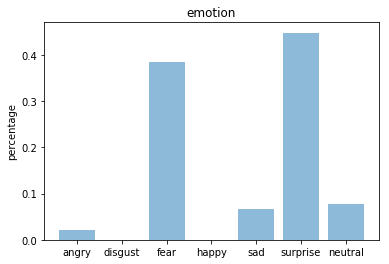

Prediction with CNN model:-


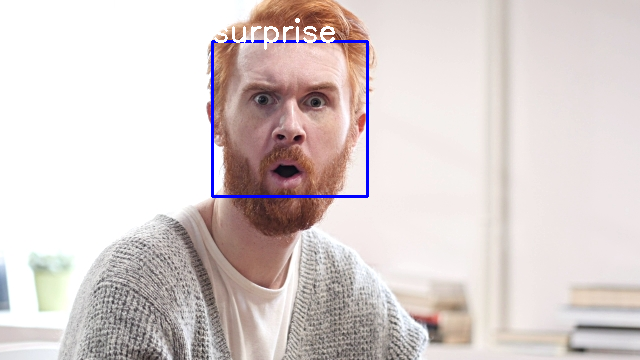

Prediction with facial landmarks:-


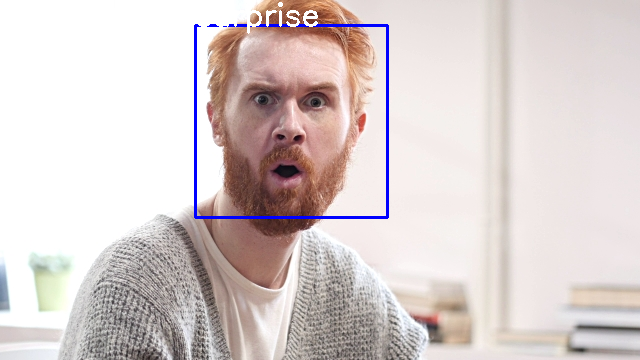

In [70]:
emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
path='drive/gaze/'
face_cascade = cv2.CascadeClassifier(path + 'haarcascade_frontalface_default.xml')
img = cv2.imread('/content/gdrive/My Drive/CSCE633Data/surprise.jpg')
org=cv2.imread('/content/gdrive/My Drive/CSCE633Data/surprise.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #transform image to gray scale
#gray=img
faces = face_cascade.detectMultiScale(gray,1.3,5)
for (x,y,w,h) in faces:
      #print(faces)
          cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
          
          detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face
          detected_face = cv2.cvtColor(detected_face, cv2.COLOR_BGR2GRAY) #transform to gray scale
          detected_face = cv2.resize(detected_face, (48, 48)) #resize to 48x48

          img_pixels = image.img_to_array(detected_face)
          img_pixels = np.expand_dims(img_pixels, axis = 0)
          uu=img_pixels
          img_pixels /= 255 #pixels are in scale of [0, 255]. normalize all pixels in scale of [0, 1]

          predictions = (0.4*model.predict(img_pixels))+(model2.predict(img_pixels)*0.6) #store probabilities of 7 expressions
          #find max indexed array 0: angry, 1:disgust, 2:fear, 3:happy, 4:sad, 5:surprise, 6:neutral
          max_index = np.argmax(predictions[0])
          emotion_analysis(predictions[0])
          emotion = emotions[max_index]
          cv2.putText(img, emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
print("Prediction with CNN model:-")
imshow(img)
faces = face_cascade.detectMultiScale(gray,2,5)
for (x,y,w,h) in faces:
      #print(faces)      
          detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face
          detected_face = cv2.cvtColor(detected_face, cv2.COLOR_BGR2GRAY) #transform to gray scale
          detected_face = cv2.resize(detected_face, (48, 48)) #resize to 48x48
          detected_face=detected_face.astype(np.uint8)
          clahe_image = clahe.apply(detected_face)
          landmarks_vectorised = get_landmarks(clahe_image)
          cv2.rectangle(org,(x,y),(x+w,y+h),(255,0,0),2)
          k=[]
          k.append(landmarks_vectorised)
          if landmarks_vectorised!='error':
                    predictions = clf.predict(np.array(k)) #store probabilities of 7 expressions
                    #find max indexed array 0: angry, 1:disgust, 2:fear, 3:happy, 4:sad, 5:surprise, 6:neutral
                    max_index = predictions
                    emotion = emotions[max_index[0]]
                    cv2.putText(org, emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
print("Prediction with facial landmarks:-")
imshow(org)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(x_train_vec, y_train_vec)
pred_lin = logreg.score(x_test_vec, y_test_vec)
print ("Model: ", pred_lin)
accur_lin.append(pred_lin) 

In [0]:

# create model

model = Sequential()
model.add(Dense(256, input_dim=268, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(x_train_vec, y_train_vec, epochs=10, batch_size=10, validation_data=(x_test_vec, y_test_vec))
